In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVR

In [4]:
train = pd.read_csv("train.csv",parse_dates=["Date"])
test = pd.read_csv("test.csv",parse_dates=["Date"])
store = pd.read_csv("store.csv")
sample = pd.read_csv("sample_submission.csv")
sample = sample.drop(["Sales"],axis=1)

print("If no data, store is open as most of the days it's open")
train =train.fillna(1)
test=test.fillna(1)

print("Consider only open stores for training. Closed stores wont count into the score")
train = train[train["Open"] != 0]
print("Use only Sales bigger then zero")
train = train[train["Sales"] > 0]


C:\Users\tomar\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


If no data, store is open as most of the days it's open
Consider only open stores for training. Closed stores wont count into the score.
Use only Sales bigger then zero


In [5]:
train = pd.merge(train,store,on="Store")
test = pd.merge(test,store,on="Store")

In [6]:
print(" Nulls in train data: \n")
print(train.isna().sum())
print("\n Nulls in test data: \n")
print(test.isna().sum())

 Nulls in train data: 

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2186
CompetitionOpenSinceMonth    268600
CompetitionOpenSinceYear     268600
Promo2                            0
Promo2SinceWeek              423292
Promo2SinceYear              423292
PromoInterval                423292
dtype: int64

 Nulls in test data: 

Id                               0
Store                            0
DayOfWeek                        0
Date                             0
Open                             0
Promo                            0
StateHoliday                     0
SchoolHoliday                    0
StoreType  

In [7]:
def feature_engg(data):
    mappings = {'0':"0", 'a':"1", 'b':"2", 'c':"3", 'd':"4"}
    mappings1 = {'0':"0", 'Jan,Apr,Jul,Oct':"1", 'Feb,May,Aug,Nov':"2", 'Mar,Jun,Sept,Dec':"3"}
    data["StoreType"].replace(mappings, inplace=True)
    data["PromoInterval"].replace(mappings1, inplace=True)
    data.Assortment.replace(mappings, inplace=True)
    data.StateHoliday.replace(mappings, inplace=True)
    
    data['Year'] = data.Date.dt.year
    data['Month'] = data.Date.dt.month
    data['Day'] = data.Date.dt.day
    data['WeekOfYear'] = data.Date.dt.weekofyear
    data['Day_Week'] = data.Date.dt.weekday_name
    mappings2 = {'Sunday':"0", 'Monday':"1", 'Tuesday':"2", 'Wednesday':"3", 'Thursday':"4", 'Friday':"5", 'Saturday':"6"}
    data["Day_Week"].replace(mappings2, inplace=True)
    data['CompetitionOpen'] = 12 * (data.Year - data.CompetitionOpenSinceYear) + \
        (data.Month - data.CompetitionOpenSinceMonth)
    data['CompetitionOpen'] = data.CompetitionOpen.apply(lambda x: x if x > 0 else 0)
    data['PrvsHoliday'] = np.where((data["StateHoliday"].shift(1)==1) | (data["SchoolHoliday"].shift(1)==1),1,0)
    data['NxtHoliday'] = np.where((data["StateHoliday"].shift(-1)==1) | (data["SchoolHoliday"].shift(-1)==1),1,0)
    data['PromoOpen'] = 12 * (data.Year - data.Promo2SinceYear) + \
        (data.WeekOfYear - data.Promo2SinceWeek) / 4.0
    data['PromoOpen'] = data["PromoOpen"].apply(lambda x: x if x > 0 else 0)
    data.loc[data.Promo2SinceYear == 0, 'PromoOpen'] = 0
    
    return data

In [8]:
train = feature_engg(train)
test = feature_engg(test)

In [9]:
#train.isna().sum()

(array([645965., 106452.,  60444.,  14705.,   6359.,   4107.,   2348.,
           885.,      0.,    887.]),
 array([2.0000e+01, 7.6040e+03, 1.5188e+04, 2.2772e+04, 3.0356e+04,
        3.7940e+04, 4.5524e+04, 5.3108e+04, 6.0692e+04, 6.8276e+04,
        7.5860e+04]),
 <a list of 10 Patch objects>)

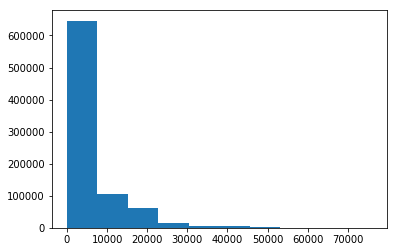

In [10]:
plt.hist(train["CompetitionDistance"].dropna())

In [11]:
train["CompetitionDistance"].fillna(np.median(train["CompetitionDistance"].dropna()),inplace=True)

(array([ 41656.,  52680.,  72253.,  32858.,  37756.,  49008.,  29961.,
         95467.,  46192., 117907.]),
 array([ 1. ,  2.1,  3.2,  4.3,  5.4,  6.5,  7.6,  8.7,  9.8, 10.9, 12. ]),
 <a list of 10 Patch objects>)

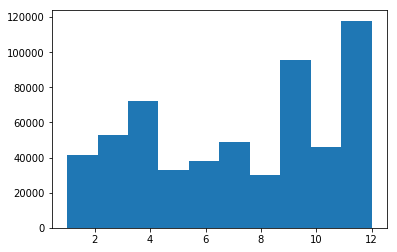

In [12]:
plt.hist(train["CompetitionOpenSinceMonth"].dropna())

In [13]:
train =train.fillna(0)
test =test.fillna(0)

In [14]:
print(train.shape)
train.head()

(844338, 27)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,PromoInterval,Year,Month,Day,WeekOfYear,Day_Week,CompetitionOpen,PrvsHoliday,NxtHoliday,PromoOpen
0,1,5,2015-07-31,5263,555,1,1,0,1,3,...,0,2015,7,31,31,5,82.0,0,1,0.0
1,1,4,2015-07-30,5020,546,1,1,0,1,3,...,0,2015,7,30,31,4,82.0,1,1,0.0
2,1,3,2015-07-29,4782,523,1,1,0,1,3,...,0,2015,7,29,31,3,82.0,1,1,0.0
3,1,2,2015-07-28,5011,560,1,1,0,1,3,...,0,2015,7,28,31,2,82.0,1,1,0.0
4,1,1,2015-07-27,6102,612,1,1,0,1,3,...,0,2015,7,27,31,1,82.0,1,0,0.0


In [15]:
print(test.shape)
test.head()

(41088, 26)


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,...,PromoInterval,Year,Month,Day,WeekOfYear,Day_Week,CompetitionOpen,PrvsHoliday,NxtHoliday,PromoOpen
0,1,1,4,2015-09-17,1.0,1,0,0,3,1,...,0,2015,9,17,38,4,84.0,0,0,0.0
1,857,1,3,2015-09-16,1.0,1,0,0,3,1,...,0,2015,9,16,38,3,84.0,0,0,0.0
2,1713,1,2,2015-09-15,1.0,1,0,0,3,1,...,0,2015,9,15,38,2,84.0,0,0,0.0
3,2569,1,1,2015-09-14,1.0,1,0,0,3,1,...,0,2015,9,14,38,1,84.0,0,0,0.0
4,3425,1,7,2015-09-13,0.0,0,0,0,3,1,...,0,2015,9,13,37,0,84.0,0,0,0.0


In [16]:
#def type_conv(df):
#    df['Store'] = df['Store'].astype('category')
#    df['DayOfWeek'] = df['Store'].astype('category')
#    df['StateHoliday'] = df['StateHoliday'].astype('category')
#    df['SchoolHoliday'] = df['SchoolHoliday'].astype('category')
#    df['Assortment'] = df['Assortment'].astype('category')
#    df['StoreType'] = df['StoreType'].astype('category')
#    df['Promo2']= df['Promo2'].astype('category')
#    df['PromoInterval']= df['Promo2'].astype('category')
#    return df

In [17]:
#train = type_conv(train)
#test = type_conv(test)

In [18]:
train = train.drop(["CompetitionOpenSinceMonth","CompetitionOpenSinceYear","Customers","Promo2SinceWeek","Promo2SinceYear"],axis=1)
test = test.drop(["CompetitionOpenSinceMonth","CompetitionOpenSinceYear","Promo2SinceWeek","Promo2SinceYear"],axis=1)

In [19]:
train.shape[0]

844338

In [20]:
df = pd.get_dummies(train[["StoreType","Assortment",
                          "PromoInterval"]],prefix_sep="_",drop_first=True)
df1 = pd.get_dummies(test[["StoreType","Assortment",
                          "PromoInterval"]],prefix_sep="_",drop_first=True)

In [21]:
train = pd.concat([train,df],axis=1)
test = pd.concat([test,df1],axis=1)

In [22]:
def rmspe(y, yhat):
    return np.sqrt(np.mean(((y - yhat)/y) ** 2))

def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y, yhat)

In [23]:
X_train = train.drop(["Sales","Date","Open",],axis=1)
y_train = train["Sales"]
X_test = test.drop(["Id","Date","Open",],axis=1)

In [24]:
scaler = StandardScaler()
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=15)
X_train_scale = scaler.fit_transform(X_train)
X_val_scale = scaler.transform(X_val)
X_test_scale = scaler.transform(X_test)

In [25]:
inner_cv = KFold(n_splits=4, shuffle=True, random_state=0)
outer_cv = KFold(n_splits=4, shuffle=True, random_state=0)

In [28]:
import xgboost as xgb
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.1,
          "max_depth": 10,
          "subsample": 0.85,
          "colsample_bytree": 0.4,
          "min_child_weight": 6,
          "silent": 1,
          "thread": 1,
          "seed": 1301
          }
num_boost_round = 2000


y_train = np.log(y_train)
y_val1 = np.log(y_val)
dtrain = xgb.DMatrix(X_train_scale, y_train)
dvalid = xgb.DMatrix(X_val_scale, y_val1)

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

In [29]:
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, early_stopping_rounds=10, \
  feval=rmspe_xg, verbose_eval=True)


[0]	train-rmse:1.50262	eval-rmse:8.10174	train-rmspe:0.877449	eval-rmspe:0.999837
Multiple eval metrics have been passed: 'eval-rmspe' will be used for early stopping.

Will train until eval-rmspe hasn't improved in 10 rounds.
[1]	train-rmse:1.35249	eval-rmse:7.95172	train-rmspe:0.836664	eval-rmspe:0.999782
[2]	train-rmse:1.21739	eval-rmse:7.81671	train-rmspe:0.794348	eval-rmspe:0.999726
[3]	train-rmse:1.0958	eval-rmse:7.69519	train-rmspe:0.75106	eval-rmspe:0.999668
[4]	train-rmse:0.986401	eval-rmse:7.58584	train-rmspe:0.707344	eval-rmspe:0.99961
[5]	train-rmse:0.88796	eval-rmse:7.48743	train-rmspe:0.663703	eval-rmspe:0.999552
[6]	train-rmse:0.799381	eval-rmse:7.39886	train-rmspe:0.620591	eval-rmspe:0.999495
[7]	train-rmse:0.719674	eval-rmse:7.31915	train-rmspe:0.578404	eval-rmspe:0.999439
[8]	train-rmse:0.64793	eval-rmse:7.24738	train-rmspe:0.53747	eval-rmspe:0.999385
[9]	train-rmse:0.583381	eval-rmse:7.18279	train-rmspe:0.498043	eval-rmspe:0.999332
[10]	train-rmse:0.525308	eval-rmse:

In [30]:
print("Validating")
yhat1 = gbm.predict(xgb.DMatrix(X_val_scale))
error = rmspe(y_val, np.exp(yhat1))
print('RMSPE: {:.6f}'.format(error))

print("Make predictions on the test set")
dtest = xgb.DMatrix(X_test_scale)
test_probs = gbm.predict(dtest)

Validating
RMSPE: 0.999195
Make predictions on the test set


In [31]:
from sklearn.ensemble import RandomForestRegressor
rfr=RandomForestRegressor(n_estimators=50)
rfr.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [32]:
print("Validating")
yhat = rfr.predict(X_val)
error = rmspe(y_val, np.exp(yhat))
print('RMSPE: {:.6f}'.format(error))

print("Make predictions on the test set")
test_probs_rfr = rfr.predict(X_test)

Validating
RMSPE: 0.998520
Make predictions on the test set


In [ ]:
rmspe(y_val, np.exp(yhat2))

In [ ]:
lsvr = LinearSVR(C=.01).fit(X_train_scale,y_train)
model = SelectFromModel(lsvr, prefit=True)
X_train_scale_sm = model.transform(X_train_scale)
print(X_train_scale_sm.shape)
X_test_scale_sm = model.transform(X_test_scale)
print(X_train_scale.shape)

In [ ]:
from sklearn.svm import SVR, LinearSVR
svr = LinearSVR(C=0.01)
svr.fit(X_train_scale_sm,y_train)

In [ ]:
X_val_scale_sm = model.transform(X_val_scale)
print("Validating")
yhat = svr.predict(X_val_scale_sm)
error = rmspe(y_val, np.exp(yhat))
print('RMSPE: {:.6f}'.format(error))

print("Make predictions on the test set")
test_probs_svr = svr.predict(X_test_scale_sm)

In [ ]:
regr = LinearRegression()
X_val_scale_sm = model.transform(X_val_scale)

In [ ]:
regr.fit(X_train_scale_sm,y_train)
print("Validating Linear Regression")
yhat_lr = regr.predict(X_val_scale_sm)
error = rmspe(y_val, np.exp(yhat_lr))
print('RMSPE: {:.6f}'.format(error))

print("Make predictions on the test set")
test_probs_lr = regr.predict(X_test_scale_sm)

In [ ]:
from sklearn.linear_model import Lasso,Ridge
from sklearn.metrics.scorer import make_scorer
my_scorer = make_scorer(rmspe, greater_is_better=False)

In [ ]:
p_grid = {'alpha': [1e-3,1e-2,1e-1]}
lasso = Lasso()
# Non_nested parameter search and scoring
gs = GridSearchCV(estimator=lasso, param_grid=p_grid,
 cv=inner_cv, scoring=my_scorer, return_train_score=True)
gs.fit(X_train_scale_sm, y_train)

In [ ]:
print("Validating Lasso")
yhat_lr = gs.predict(X_val_scale_sm)
error = rmspe(y_val, np.exp(yhat_lr))
print('RMSPE: {:.6f}'.format(error))
print('Best params are: {0}'.format(gs.best_params_))

print("Make predictions on the test set")
test_probs_lr = regr.predict(X_test_scale_sm)

In [ ]:
p_grid = {'alpha': [1e-3,1e-2,1e-1]}
ridge = Ridge()
# Non_nested parameter search and scoring
gs = GridSearchCV(estimator=ridge, param_grid=p_grid,
 cv=inner_cv, scoring=my_scorer,return_train_score=True)
gs.fit(X_train_scale_sm, y_train)

In [ ]:
print("Validating Ridge")
yhat_lr = gs.predict(X_val_scale_sm)
error = rmspe(y_val, np.exp(yhat_lr))
print('RMSPE: {:.6f}'.format(error))
print('Best params are: {0}'.format(gs.best_params_))
print("Make predictions on the test set")
test_probs_lr = regr.predict(X_test_scale_sm)

In [ ]:
# Make Submission
result = pd.DataFrame({"Id": test["Id"], 'Sales': np.exp(test_probs), "open":test['Open']})
#result["Sales"]=np.where(result["open"]==0,0,result["Sales"])
result=result.drop("open",axis=1)
result.to_csv("submission1.csv", index=False)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from livelossplot import PlotLossesKeras
import tensorflow as tf
from keras import optimizers
from keras import regularizers
import keras.backend as K
from keras.layers import LSTM,GRU
from keras.layers.core import Dense, Activation, Dropout

In [ ]:
def RMSPE_for_Keras(y, yhat):
    return K.sqrt(K.mean(((y - yhat)/y) ** 2))

In [ ]:
s = tf.InteractiveSession()
model = Sequential()
model.add(Dense(50, input_dim=np.shape(X_train_scale)[1],activation='relu',kernel_initializer = 'uniform'))
model.add(Dropout(0.2))
model.add(Dense(25,activation='relu',kernel_initializer = 'uniform'))
model.add(Dropout(0.2))
model.add(Dense(10,activation='relu',kernel_initializer = 'uniform'))
model.add(Dense(1))

#sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(loss='mean_absolute_percentage_error', optimizer='adam')
model.fit(X_train_scale, y_train, epochs=20,batch_size=200, verbose=1,callbacks=[PlotLossesKeras()],validation_data=(
    X_val_scale, y_val1))

In [ ]:
print("Validating")
yhat_mlp = model.predict(X_val_scale)
yhat_mlp = [x[0] for x in yhat_mlp]
error = rmspe(y_val, np.exp(yhat_mlp))
print('RMSPE: {:.6f}'.format(error))

print("Make predictions on the test set")
test_probs_mlp = model.predict(X_test_scale)

In [ ]:
X_train_scale_rs = np.reshape(X_train_scale, (X_train_scale.shape[0],X_train_scale.shape[1],1))
X_val_scale_rs = np.reshape(X_val_scale, (X_val_scale.shape[0],X_val_scale.shape[1],1))
X_test_scale_rs = np.reshape(X_test_scale, (X_test_scale.shape[0],X_test_scale.shape[1],1))